In [25]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc

# Import the data
Data will be in scanpy anndata type


In [26]:
rawPath = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "Datasets", "DUSP1", "A1-2_sc_Bulk_GSE141834", 'GSE141834_scRNAseq_rawCounts.txt')
adata = sc.read_text(rawPath).T
adata.write_h5ad("GSE141834_scRNAseq_rawCounts.h5ad")

# Quality Contorl
Genes and cells that dont contribute information <br>
based on: genes that arent in at least 10 cells and cells that dont have at least 100 genes

In [27]:
sc.pp.filter_genes(adata, min_cells = 10)
sc.pp.filter_cells(adata, min_genes = 100)

Creates a 'mt' and 'ribo' column in var dataframe, <br>
with boolean values incicateing if the gene is a <br>
a mitochondrial and rRNA<br>
then creates several measurements obs and var <br>



In [28]:
adata.var['mt'] = adata.var.index.str.startswith('MT-')
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header = None)
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

Display QC variables 

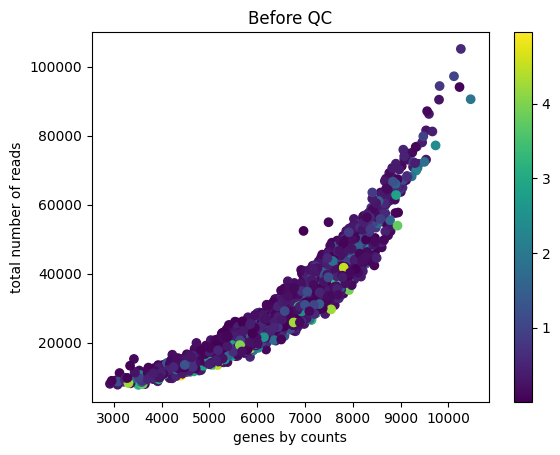

In [29]:
plt.scatter(adata.obs['n_genes_by_counts'], adata.obs['total_counts'], c=adata.obs['pct_counts_mt'])
plt.xlabel('genes by counts')
plt.ylabel('total number of reads')
plt.title("Before QC")
plt.colorbar()
plt.show()

Saves raw data to counts layer 

In [30]:
adata.layers['counts'] = adata.X

Seurat_v3 highly variable genes saved to seurat_V3_HV <br>
as boolean

In [31]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes = 4000)

In [32]:
adata.var['seurat_v3_HVG'] = adata.var['highly_variable']

Normalize data to 10,000 counts 

In [33]:
sc.pp.normalize_total(adata, target_sum = 1e5)


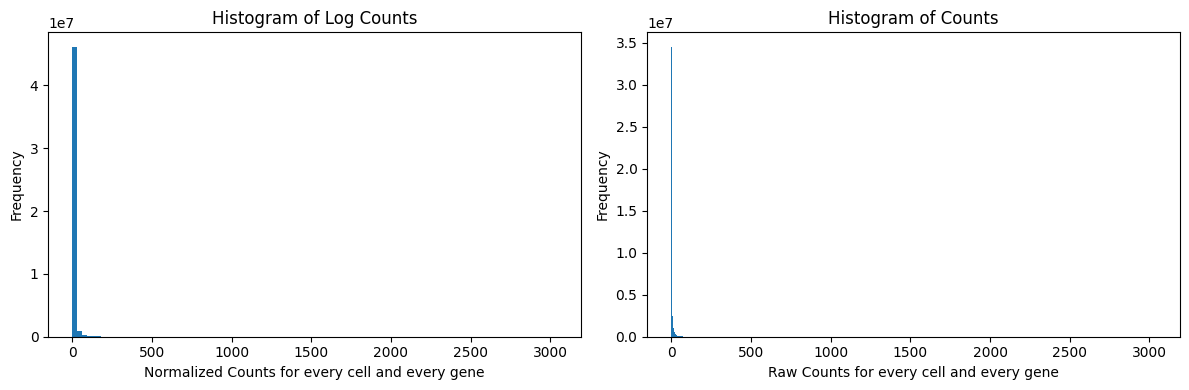

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Normalized Counts
axs[0].hist(adata.X.flatten(), bins=100)
axs[0].set_xlabel('Normalized Counts for every cell and every gene')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Log Counts')

# Plot 2: Counts
axs[1].hist(adata.layers['counts'].flatten(), bins=1000)
axs[1].set_xlabel('Raw Counts for every cell and every gene')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Counts')

plt.tight_layout()
plt.show()


Converts data to log(x + 1)

In [35]:
sc.pp.log1p(adata)
adata.raw = adata

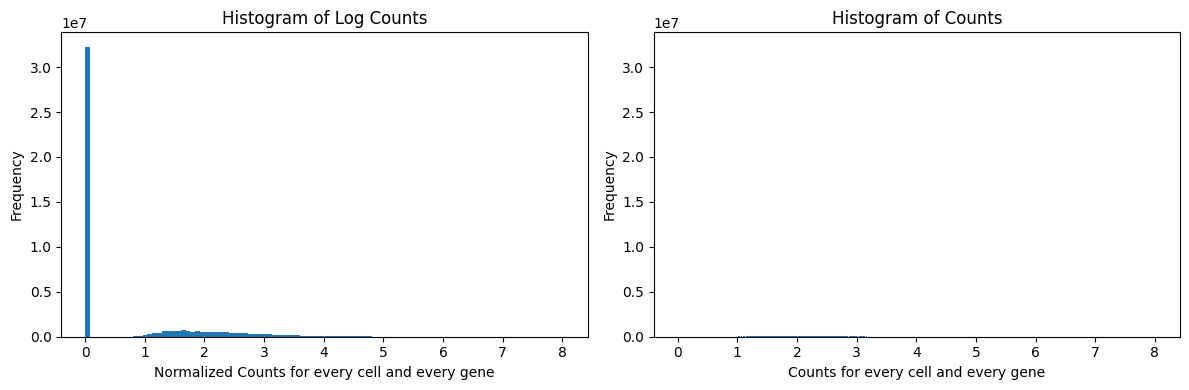

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Log Counts
axs[0].hist(adata.X.flatten(), bins=100)
axs[0].set_xlabel('Normalized Counts for every cell and every gene')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Histogram of Log Counts')

# Plot 2: Raw Counts
axs[1].hist(adata.layers['counts'].flatten(), bins=1000)
axs[1].set_xlabel('Counts for every cell and every gene')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Histogram of Counts')

plt.tight_layout()
plt.show()


Adds Timepoint to obs, strings of a XX format strings for each TP <br>
Add Treatment to obs, strings that are Dex 

In [37]:
adata.obs['Timepoint'] = [x.split('.')[1] for x in adata.obs_names]
adata.obs['Treatment'] = [x.split('.')[0] for x in adata.obs_names]

adata.obs['Timepoint'] = adata.obs['Timepoint']
adata.obs['Treatment'] = adata.obs['Treatment']

Removes none Dex treated cells

In [38]:
adata = adata[adata.obs['Treatment'] == 'Dex']

Checks to make sure all vars are only gene

In [39]:
lsChecks = [
    'day', 'DUSP1', 'hashtag', 'timepoint', 'treatment', 'treatment_timepoint', 'treatment_timepoint_day', 'treatment_day', 'treatment_timepoint_day',
    'treatment_timepoint', 'treatment_timepoint_day', 'treatment_day', 'treatment_timepoint_day', 'treatment_timepoint', 'treatment_timepoint_day', 'hash',
    'tag' 

]

new_tags = ['experiment_id', 'sample_id', 'batch', 'cell_type', 
            'condition', 'replicate', 'protocol', 'operator', 'date', 
            'location', 'species', 'strain', 'sex', 'age', 'developmental_stage', 
            'tissue', 'organ', 'cell_line', 'disease_state', 'platform', 'sequencing_depth', 
            'read_length', 'library_type', 'experiment_type', 'analysis_software', 'sample', 'type', 'name', 'id', 'group',
            'experiment', 'cell', 'read', 'type', adata.var_names[483]]

lsChecks.extend(new_tags)

new_tags = ['genotype', 'phenotype', 'molecule', 'barcode', 'cell_cycle', 'population', 
            'cluster', 'subpopulation', 'marker', 'antibody', 'probe', 'primer', 'temperature', 
            'humidity', 'pressure', 'light_cycle', 'food_source', 'lifecycle_stage', 'growth_conditions', 
            'experiment_conditions', 'lab', 'researcher', 'project', 'publication', 'cycle', 'dex', adata.var_names[1849], 'GH', 'dusp']


lsChecks.extend(new_tags)
print(len(lsChecks))
for i in lsChecks:
    for name in adata.var_names:
        if i.lower() in name.lower():
            print(f'{i} is in the var_names, {name}')




81
DUSP1 is in the var_names, DUSP13
DUSP1 is in the var_names, DUSP1
DUSP1 is in the var_names, DUSP18
DUSP1 is in the var_names, DUSP11
DUSP1 is in the var_names, DUSP12
DUSP1 is in the var_names, DUSP14
DUSP1 is in the var_names, DUSP16
DUSP1 is in the var_names, DUSP19
DUSP1 is in the var_names, DUSP10
DUSP1 is in the var_names, DUSP15
tag is in the var_names, STAG3L3
tag is in the var_names, STAG1
tag is in the var_names, TAGLN2
tag is in the var_names, STAG3L5P
tag is in the var_names, STAG3L5P-PVRIG2P-PILRB
tag is in the var_names, STAG2
tag is in the var_names, CTAGE5
tag is in the var_names, STAG3
tag is in the var_names, STAG3L4
tag is in the var_names, TAGLN
tag is in the var_names, STAG3L2
age is in the var_names, MAGEH1
age is in the var_names, XAGE1A
age is in the var_names, LAGE3
age is in the var_names, MAGEA1
age is in the var_names, LAGE3P1
age is in the var_names, GAGE1
age is in the var_names, BAGE2
age is in the var_names, MAGEA12
age is in the var_names, XAGE2
age

dex is in the var_names, DEXI
PEX2 is in the var_names, PEX26
PEX2 is in the var_names, PEX2
PEX2 is in the var_names, APEX2
GH is in the var_names, PIGH
GH is in the var_names, PGGHG
GH is in the var_names, GGH
GH is in the var_names, GHDC
GH is in the var_names, HAGHL
GH is in the var_names, HAGH
GH is in the var_names, IGHEP1
GH is in the var_names, GHITM
GH is in the var_names, IGHE
GH is in the var_names, GHRL
GH is in the var_names, GHRH
GH is in the var_names, IGHG3
GH is in the var_names, PIGHP1
GH is in the var_names, IGHMBP2
GH is in the var_names, IGHA1
GH is in the var_names, GHR
GH is in the var_names, GHRLOS
GH is in the var_names, GHRHR
dusp is in the var_names, DUSP13
dusp is in the var_names, DUSP1
dusp is in the var_names, DUSP23
dusp is in the var_names, DUSP8
dusp is in the var_names, DUSP28
dusp is in the var_names, DUSP18
dusp is in the var_names, DUSP11
dusp is in the var_names, DUSP4
dusp is in the var_names, DUSP5
dusp is in the var_names, DUSP12
dusp is in the

Select Only Highly Variable using 3 methods

In [40]:
sc.pp.highly_variable_genes(adata, layer='counts', flavor='seurat')
adata.var['seurat_HVG'] = adata.var['highly_variable']
print(adata.var['seurat_HVG'])

/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:544: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


CTSH          False
SFXN4         False
AC127537.3    False
DCAF8L1       False
RBM45         False
              ...  
PLXNA2         True
CD4            True
PCDH17         True
AC004264.2     True
CHI3L2         True
Name: seurat_HVG, Length: 19841, dtype: bool


In [41]:
sc.pp.highly_variable_genes(adata, flavor='cell_ranger')
adata.var['cell_ranger_HVG'] = adata.var['highly_variable']
print(adata.var['cell_ranger_HVG'])

CTSH          False
SFXN4         False
AC127537.3    False
DCAF8L1       False
RBM45         False
              ...  
PLXNA2        False
CD4           False
PCDH17         True
AC004264.2     True
CHI3L2         True
Name: cell_ranger_HVG, Length: 19841, dtype: bool


/home/formanj/scRNAseq_model/UpDownProject/.venv/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:252: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']


In [56]:
common_genes = list(set(adata.var_names[adata.var['cell_ranger_HVG']]) & set(adata.var_names[adata.var['seurat_HVG']]) & set(adata.var_names[adata.var['seurat_v3_HVG']]))
print(len(common_genes))

union_genes = list(set(adata.var_names[adata.var['cell_ranger_HVG']])) + list(set(adata.var_names[adata.var['seurat_HVG']])) + list(set(adata.var_names[adata.var['seurat_v3_HVG']]))
print(len(union_genes))

1587
12530
